<span>
<b>Author:</b> Chenxiang Zhang <br/>
<b>Python version:</b>  3.x <br/>
</span>

## Data Understanding
...

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr
plt.style.use('ggplot')

### Load the Dataset
Load the Dataset and have a first glimpse on the data

In [2]:
df = pd.read_csv('../../data/sales_ram.csv', sep=',')
df

,Unnamed: 0,Id,ram_code,time_code,geo_code,vendor_code,sales_usd,sales_currency
0,2602347,3719,1.0,20130322,25,32,13.749032,10.65
1,2602348,3719,1.0,20130323,18,32,13.828708,10.65
2,2602349,3719,1.0,20130326,28,32,13.694297,10.65
3,2602350,3719,1.0,20130327,25,32,13.690530,10.65
4,2602351,3719,1.0,20130328,27,32,13.605216,10.65
...,...,...,...,...,...,...,...,...
3412326,6014673,7422,3704.0,20170310,69,47,614.130000,614.13
3412327,6014674,7422,3704.0,20170505,75,47,614.130000,614.13
3412328,6014675,7422,3704.0,20170510,70,47,614.130000,614.13
3412329,6014676,7422,3704.0,20170511,69,47,614.130000,614.13


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412331 entries, 0 to 3412330
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   Id              int64  
 2   ram_code        float64
 3   time_code       int64  
 4   geo_code        int64  
 5   vendor_code     int64  
 6   sales_usd       float64
 7   sales_currency  float64
dtypes: float64(3), int64(5)
memory usage: 208.3 MB


### Features Description
Each record of the dataset 'sales_ram' represent a sale transaction by a vendor. We describe what each feature represent and decide what to do with them.
- __Unnamed: 0__: Redundant column that is a progressive counter, we remove this and use the counter generated by pandas
- __Id__: Redundant column representing the ram_code with an offset of +3719. We remove this and use only the ram_code
- __ram_code__: Represent uniquely the type of ram that has been sold in the transaction
- __time_code__: Represent uniquely the date when the transaction is performed
- __geo_code__: Represent uniquely the location where the transaction is performed. Each code uniquely represent an sub-area of a country and its currency. E.g. _Oceania,New Zeland,south island northern,NZD_
- __vendor_code__: Represent the vendor company that sold the product
- __sales_usd__: Represent the transaction's value in the normalized currency USD
- __sales_currency__: Represent the transaction's value in the geo_code's currency.


In [4]:
print(f"Unique ram \t\t: {len(df['ram_code'].unique())}")
print(f"Unique time_code \t: {len(df['time_code'].unique())}")
print(f"Unique geo_code \t: {len(df['geo_code'].unique())}")
print(f"Unique vendor_code \t: {len(df['vendor_code'].unique())}")
print(f"Unique sales_usd \t: {len(df['sales_usd'].unique())}")

Unique ram 		: 3119
Unique time_code 	: 1840
Unique geo_code 	: 75
Unique vendor_code 	: 78
Unique sales_usd 	: 2907289


### Small Fix
We drop the first column, since it is a redundant counter column with an offset. The first step, we convert the data types. More specifically, the attribute ram_code is converted from float64 to int64. Then we check if there's any missing values and any duplicated records.

In [5]:
df.drop(columns=['Unnamed: 0', 'Id'], inplace=True)
df = df.convert_dtypes()

In [6]:
# check if any value is missing
df.isnull().any()

ram_code          False
time_code         False
geo_code          False
vendor_code       False
sales_usd         False
sales_currency    False
dtype: bool

In [123]:
# check if there's any duplicated records
print("Beofore: \t", len(df))
df = df.drop_duplicates()
print("After: \t\t", len(df))

Beofore: 	 3412331
After: 		 3412331


### Basic Statistics
The only column we're interested in seeing the statistics is the __sales_usd__

In [7]:
df.describe()

,ram_code,time_code,geo_code,vendor_code,sales_usd,sales_currency
count,3.412331e+06,3.412331e+06,3.412331e+06,3.412331e+06,3.412331e+06,3.412331e+06
mean,1.539606e+03,2.016166e+07,3.293352e+01,3.949093e+01,1.814250e+02,1.590673e+02
std,8.536889e+02,1.309320e+04,1.896925e+01,1.416273e+01,8.536833e+03,5.426377e+03
min,1.000000e+00,2.013032e+07,1.000000e+00,1.000000e+00,7.050645e-01,5.000000e-01
25%,8.040000e+02,2.015112e+07,2.000000e+01,3.200000e+01,4.858296e+01,4.202000e+01
50%,1.423000e+03,2.016111e+07,2.600000e+01,3.200000e+01,9.906795e+01,8.760000e+01
75%,2.239000e+03,2.017081e+07,3.200000e+01,4.500000e+01,2.058690e+02,1.829000e+02
max,3.704000e+03,2.018041e+07,7.500000e+01,8.100000e+01,1.574134e+07,1.000000e+07


### Data Integration
We integrate the date with more columns trying to get a deeper understanding on the data's behaviour. 

In [261]:
df_geo = pd.read_csv("../../data/geography.csv", sep=',', usecols=[1,2,3,4,5])
df_ram = pd.read_csv("../../data/ram.csv", sep=',')
df_time = pd.read_csv("../../data/time.csv", sep=',', usecols=[1,2,3,4,5])
df_vendor = pd.read_csv("../../data/vendor.csv", sep=',', usecols=[1,2])
df_vendor.columns = ['vendor_code', 'vendor_name']

# extend the original df with more info about geography and ram vendors
df_j = df.join(df_geo.set_index('geo_code'), on='geo_code')
df_j = df_j.join(df_ram.set_index('ram_code'), on='ram_code')
df_j = df_j.join(df_time.set_index('time_code'), on='time_code')
df_j = df_j.join(df_vendor.set_index('vendor_code'), on='vendor_code')
df_j

# drop duplicate and surely not needed colums
df_j.drop(columns=['region', 'sales_currency', 'name', 'currency', 'day', 'week'], inplace=True)
df_j

,ram_code,time_code,geo_code,vendor_code,sales_usd,continent,country,brand,memory,memory_type,clock,year,month,vendor_name
0,1,20130322,25,32,13.749032,Europe,Germany,ADATA,0.5,DDR,400,2013,3,geizhals_unknown
1,1,20130323,18,32,13.828708,Europe,Germany,ADATA,0.5,DDR,400,2013,3,geizhals_unknown
2,1,20130326,28,32,13.694297,Europe,Germany,ADATA,0.5,DDR,400,2013,3,geizhals_unknown
3,1,20130327,25,32,13.690530,Europe,Germany,ADATA,0.5,DDR,400,2013,3,geizhals_unknown
4,1,20130328,27,32,13.605216,Europe,Germany,ADATA,0.5,DDR,400,2013,3,geizhals_unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412326,3704,20170310,69,47,614.130000,America,United States of America,WINTEC,64.0,DDR4,2133,2017,3,Newegg
3412327,3704,20170505,75,47,614.130000,America,United States of America,WINTEC,64.0,DDR4,2133,2017,5,Newegg
3412328,3704,20170510,70,47,614.130000,America,United States of America,WINTEC,64.0,DDR4,2133,2017,5,Newegg
3412329,3704,20170511,69,47,614.130000,America,United States of America,WINTEC,64.0,DDR4,2133,2017,5,Newegg


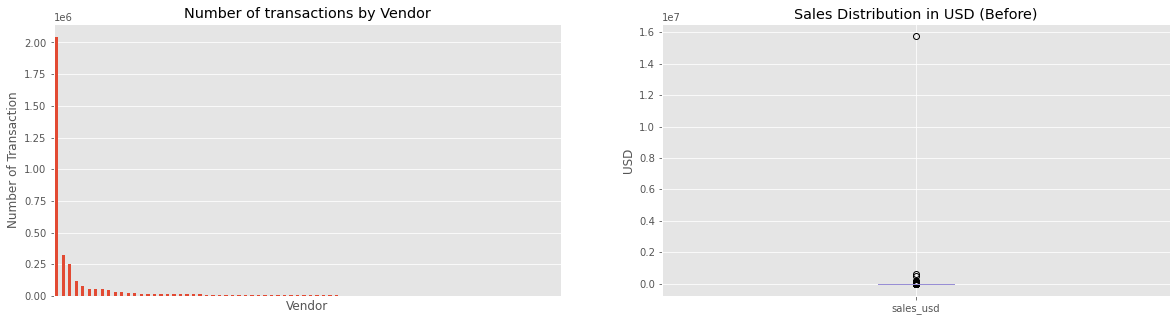

In [248]:
# Plot the distribution of sales_usd and the number of transaction by vendor
# These two attributes need to be cleaned in the Data cleaning phase, reducing the number of records
# We decide to floor the price due to the daily currency oscillation
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
df_j['vendor_code'].value_counts().plot(kind='bar', xticks=[], 
                                        xlabel='Vendor', ylabel='Number of Transaction',
                                        title='Number of transactions by Vendor')

plt.subplot2grid(fig_dims, (0, 1))
df_j['sales_usd'] = np.floor(df_j['sales_usd'])
df_j['sales_usd'].plot(kind='box', ylabel='USD', title='Sales Distribution in USD (Before)')

plt.savefig('../../tex/imgs/du_sales_and_vendor.pdf')

Germany                     2185877
United Kingdom               515973
United States of America     224135
Spain                        157599
Canada                       144653
Australia                     96396
New Zeland                    56648
France                        14808
Belgium                        9243
Ireland                        5692
Italy                          1307
Name: country, dtype: int64


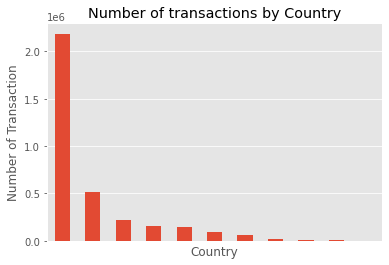

In [244]:
# Plot the transaction per country
df_j['country'].value_counts().plot(kind='bar', xticks=[], 
                                    xlabel='Country', ylabel='Number of Transaction', 
                                    title='Number of transactions by Country')
plt.savefig('../../tex/imgs/du_transaction_per_space.pdf')
print(df_j['country'].value_counts())

In [245]:
# Plot the transaction per country on a map
countries = df_j['country'].value_counts()
fig = go.Figure(
    data=go.Choropleth(
        locations=countries.index,
        z=np.log10(countries), 
        locationmode='country names', 
        colorscale='Inferno',
        colorbar_title='Log(Transactions)'))
# fig.update_layout(title_text='Number of transaction per Country')
fig.show()
fig.write_image('../../tex/imgs/du_transaction_per_space2.pdf')

ValueError: 
The orca executable is required in order to export figures as static images,
but the executable that was found at '/usr/bin/orca'
does not seem to be a valid plotly orca executable. Please refer to the end of
this message for details on what went wrong.

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python

The error encountered is that unexpected output was returned by the command
    $ /usr/bin/orca --help

b'Usage: orca [-h] [-v] [-r] [-s] [-l] [-e OPTION] [-d OPTION] [-p NAME]\n            [-u DIR] [--debug-file FILE] [--debug]\n\nOptional arguments:\n  -h, --help                   Show this help message and exit\n  -v, --version                3.36.2\n  -r, --replace                Replace a currently running instance of this\n                               screen reader\n  -s, --setup                  Set up user preferences (GUI version)\n  -l, --list-apps              Print the known running applications\n  -e OPTION, --enable OPTION   Force use of option\n  -d OPTION, --disable OPTION  Prevent use of option\n  -p NAME, --profile NAME      Load profile\n  -u DIR, --user-prefs DIR     Use alternate directory for user preferences\n  --debug-file FILE            Send debug output to the specified file\n  --debug                      Send debug output to debug-YYYY-MM-DD-\n                               HH:MM:SS.out\n\nReport bugs to orca-list@gnome.org.\n'


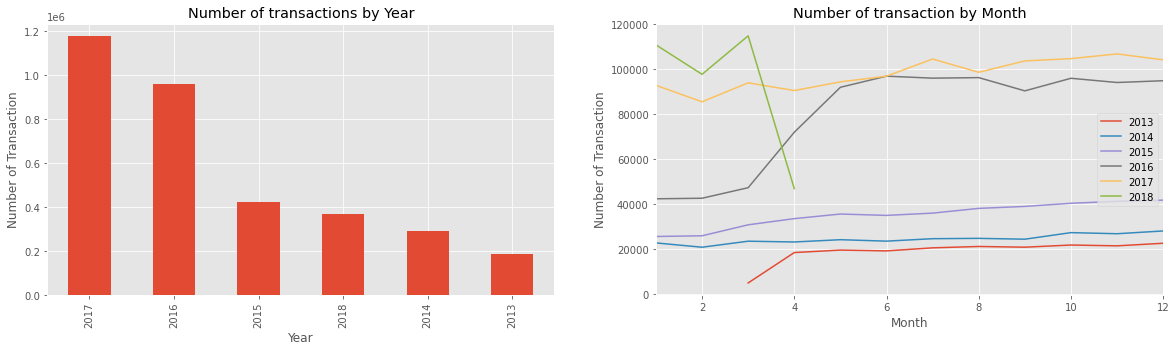

<Figure size 432x288 with 0 Axes>

In [246]:
# Plot the transaction for different periods
# The drastic increase in 2016 is because most vendors's first sale starts from 2016
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
df_j['year'].value_counts().plot(kind='bar', 
                                 xlabel='Year', ylabel='Number of Transaction', 
                                 title='Number of transactions by Year')
plt.subplot2grid(fig_dims, (0, 1))

df_j[df_j['year'] == 2013]['month'].value_counts().sort_index().plot(kind='line', xlim=[1,12], label='2013')
df_j[df_j['year'] == 2014]['month'].value_counts().sort_index().plot(kind='line', xlim=[1,12], label='2014')
df_j[df_j['year'] == 2015]['month'].value_counts().sort_index().plot(kind='line', xlim=[1,12], label='2015')
df_j[df_j['year'] == 2016]['month'].value_counts().sort_index().plot(kind='line', xlim=[1,12], label='2016')
df_j[df_j['year'] == 2017]['month'].value_counts().sort_index().plot(kind='line', xlim=[1,12], label='2017')
df_j[df_j['year'] == 2018]['month'].value_counts().sort_index().plot(kind='line', xlim=[1,12], label='2018')
plt.legend(loc='center right')
plt.xlabel('Month')
plt.ylabel('Number of Transaction')
plt.title('Number of transaction by Month')

plt.show()
plt.savefig('../../tex/imgs/du_transaction_per_time.pdf')

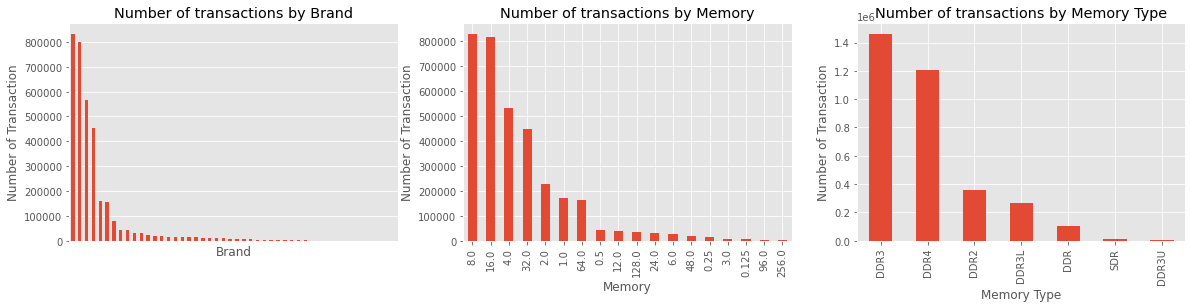

<Figure size 432x288 with 0 Axes>

In [247]:
# Plot the transaction for different ram type
fig = plt.figure(figsize=(20, 4)) 
fig_dims = (1, 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
df_j['brand'].value_counts().plot(kind='bar', xticks=[], 
                                  xlabel='Brand', ylabel='Number of Transaction',
                                  title='Number of transactions by Brand')
plt.subplot2grid(fig_dims, (0, 1))
df_j['memory'].value_counts().plot(kind='bar', 
                                   xlabel='Memory', ylabel='Number of Transaction',
                                   title='Number of transactions by Memory')
plt.subplot2grid(fig_dims, (0, 2))
df_j['memory_type'].value_counts().plot(kind='bar', 
                                        xlabel='Memory Type', ylabel='Number of Transaction',
                                        title='Number of transactions by Memory Type')

plt.show()
plt.savefig('../../tex/imgs/du_transaction_per_ram.pdf')

## Data Preparation
In this section we first clean the data reducing the number of records. Then we will create a profile {big, small} for a vendor using feature creation. And finally we will reduce the features dimension, selecting only those needed to identify a vendor profile.

### Data Cleaning
- Remove the unknown vendors since they are not profilable
- Remove the outliers data in the sales_usd

In [255]:
unknown_vendor = [name for name in df_j['vendor_name'].unique() if 'unknown' in name]

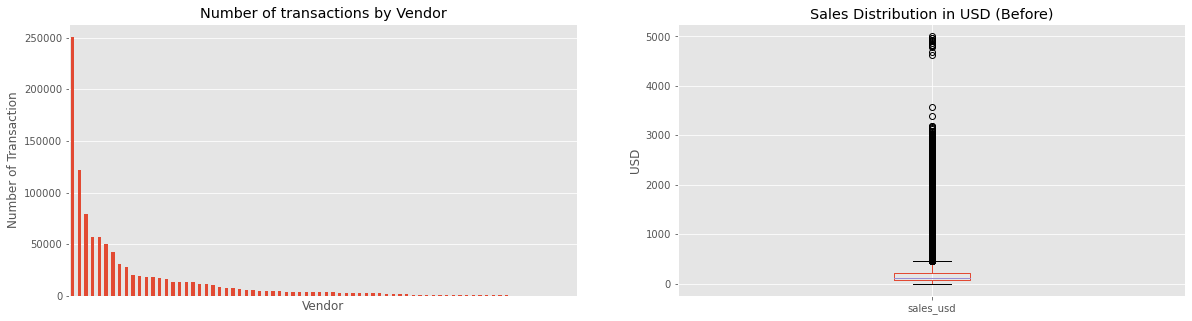

In [262]:
# Remove the unknown vendors since they are not profilable
# Remove the outliers data in the sales_usd
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
df_c = df_j[df_j['vendor_name'] != unknown_vendor[0]]
df_c = df_c[df_c['vendor_name'] != unknown_vendor[1]]
df_c['vendor_code'].value_counts().plot(kind='bar', xticks=[], 
                                        xlabel='Vendor', ylabel='Number of Transaction',
                                        title='Number of transactions by Vendor')

plt.subplot2grid(fig_dims, (0, 1))
df_c = df_c[df_c['sales_usd'] < 5000]
df_c['sales_usd'].plot(kind='box', ylabel='USD', title='Sales Distribution in USD (Before)')

plt.savefig('../../tex/imgs/du_sales_and_vendor_cleaned.pdf')

In [266]:
print("Number of transactions before: \t", len(df_j))
print("Number of transactions after: \t", len(df_c))

Number of transactions before: 	 3412331
Number of transactions after: 	 1047425


### Feature Creation
Create features that will be used to identify a vendor profile
- Number of unique ram
- Total unit sold
- Total revenue
- Days = number of days between first and last sale
- revenue per unit = Total revenue / Total unit sold
- units sold per day = Total unit sold / days

- Shannon entropy of the selling behaviour

Other?
- Recency (?)
- Frequency
- Monetary Value

In [304]:
# Computing the number of days passed between the first and last transaction sale
from datetime import date
time_first_sale = df_c.groupby('vendor_code')['time_code'].min().apply(lambda x: str(x))
time_first_sale = time_first_sale.apply(lambda x: date(int(x[:4]), int(x[4:6]), int(x[6:8])))

time_last_sale = df_c.groupby('vendor_code')['time_code'].max().apply(lambda x: str(x))
time_last_sale = time_last_sale.apply(lambda x: date(int(x[:4]), int(x[4:6]), int(x[6:8])))

days = time_last_sale - time_first_sale
days = days.apply(lambda x: x.days)

In [339]:
# Creating a new dataframe for vendor profiles
unique_ram = df_c.groupby('vendor_code')['ram_code'].nunique()
total_units_sold = df_c.groupby('vendor_code')['ram_code'].count()
total_revenue = df_c.groupby('vendor_code')['sales_usd'].sum()
revenue_per_unit = total_revenue / total_units_sold
revenue_per_day = total_revenue / days
units_sold_per_day = total_units_sold / days

df_p = pd.concat([unique_ram, total_units_sold, total_revenue, revenue_per_unit, 
                  revenue_per_day, days, units_sold_per_day], axis=1)
df_p.columns = ['unique_ram', 'total_units_sold', 'total_revenue', 'revenue_per_unit',
               'revenue_per_day', 'days', 'units_sold_per_day']
df_p

,unique_ram,total_units_sold,total_revenue,revenue_per_unit,revenue_per_day,days,units_sold_per_day
vendor_code,,,,,,,
1,60,778,1.031600e+05,132.596405,140.928966,732,1.062842
2,196,3950,5.896145e+05,149.269497,805.484306,732,5.396175
3,203,3051,4.732057e+05,155.098549,10754.674367,44,69.340909
4,101,407,5.785105e+04,142.140184,2142.631661,27,15.074074
5,276,13042,2.163237e+06,165.866942,4451.104224,486,26.835391
...,...,...,...,...,...,...,...
77,15,76,8.825052e+03,116.119106,12.072575,731,0.103967
78,128,4092,4.527215e+05,110.635742,618.471933,732,5.590164
79,270,7685,1.181234e+06,153.706466,1613.707909,732,10.498634


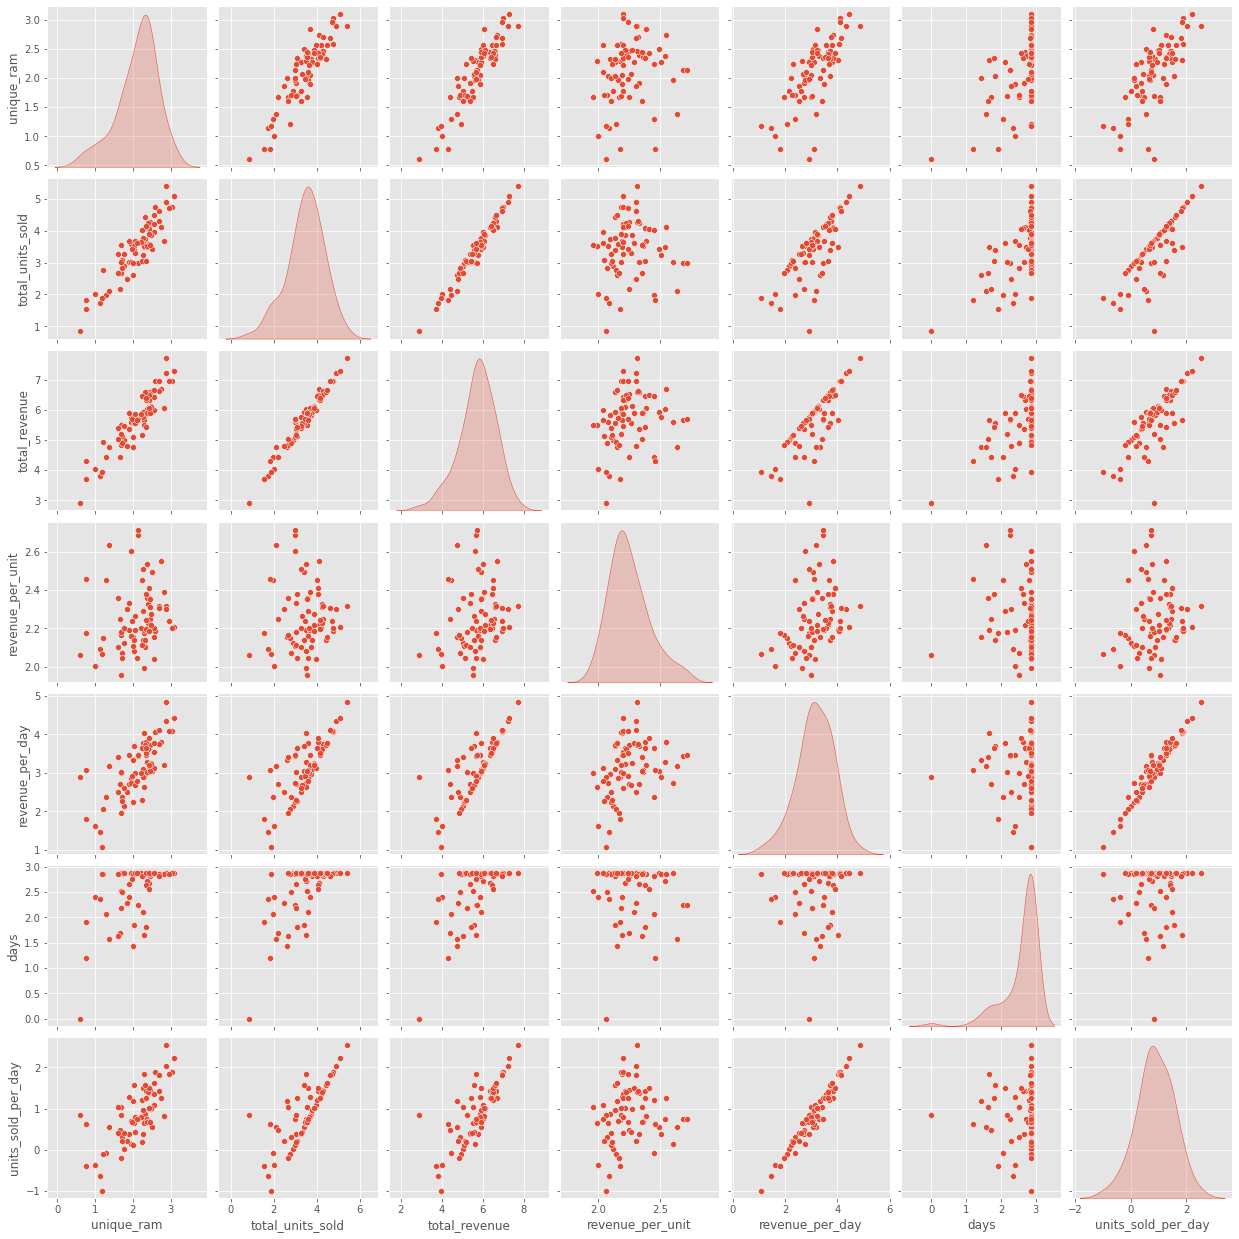

In [340]:
# normalize data
# need to save the plot
df_logp = np.log10(df_p)
sns.pairplot(df_logp, diag_kind='kde')

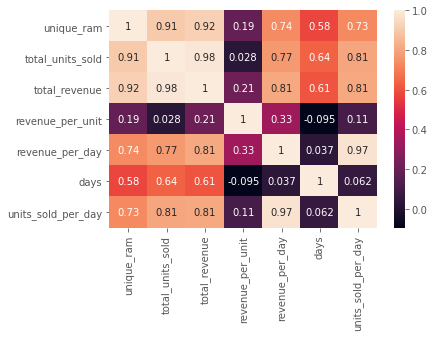

In [364]:
import seaborn as sns
sns.heatmap(df_logp.corr(), annot=True)
plt.savefig('../../tex/imgs/du_dataset_corr.pdf')

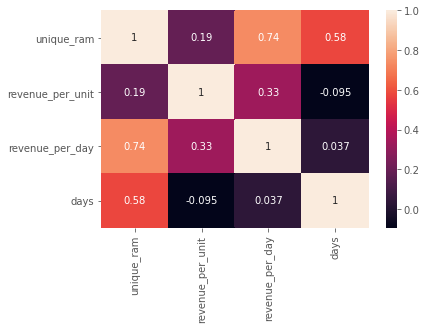

In [365]:
df_f = df_logp.drop(columns=['total_units_sold', 'units_sold_per_day', 'total_revenue'])
sns.heatmap(df_f.corr(), annot=True)
plt.savefig('../../tex/imgs/du_dataset_corr_after.pdf')
df_f.to_csv('../../data/profile/vendor_profile_log.csv', sep=',')

In [348]:
df_f = df_p.drop(columns=['total_units_sold', 'units_sold_per_day', 'total_revenue'])
# sns.heatmap(df_f.corr(), annot=True)
# plt.savefig('../../tex/imgs/du_dataset_corr_after.png')
df_f.to_csv('../../data/profile/vendor_profile.csv', sep=',')

In [363]:
revenue_per_day.sort_values(ascending=False)

vendor_code
43    70762.173511
47    26603.399459
45    21836.059620
63    13141.102080
50    12396.179955
          ...     
29       92.865072
81       62.365253
61       42.342409
66       29.164463
77       12.072575
Length: 76, dtype: float64